# **Step 1: Combining and Preprocessing 3 Datasets**
## **Datasets - Hotel Reviews**
นำเข้าชุดข้อมูลบทวิจารณ์โรงแรมมา 3 ชุดข้อมูล คือ **Hotel_Reviews.csv**, **Datafiniti_Hotel_Reviews.csv** และ **Datafiniti_Hotel_Reviews_Jun19.csv**

ชุดข้อมูลทั้ง 3 ชุดประกอบไปด้วยตัวแปรที่หลากหลาย แต่ตัวแปรบางตัวนั้นยังคงมีลักษณะที่คล้ายคลึงกัน ซึ่งพวกเราจะให้ความสนใจตัวแปรเหล่านั้นดังนี้

* reviews.rating - เป็นการให้คะแนนของผู้วิจารณ์

* reviews.title - เป็นข้อความเกริ่นนำหรือหัวข้อของบทวิจารณ์

* reviews.text - เป็นข้อความการวิจารณ์ของผู้ที่ได้เข้าพักโรงแรมในแต่ละแห่ง


URL: https://www.kaggle.com/datasets/datafiniti/hotel-reviews/data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [68]:


df1 = pd.read_csv('/content/drive/MyDrive/Data Engineering/Hotel_Reviews.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Data Engineering/Datafiniti_Hotel_Reviews.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Data Engineering/Datafiniti_Hotel_Reviews_Jun19.csv')

In [3]:
df1.head(1)

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN


In [4]:
df2.head(1)

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com


In [5]:
df3.head(1)

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AWE2FvX5RxPSIh2RscTK,2018-01-18T18:43:12Z,2019-05-20T23:55:47Z,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.44178,...,2018-01-03T00:00:00Z,3,https://www.tripadvisor.com/Hotel_Review-g3243...,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,UnitedStates,tatsurok2018,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...


### Data Transformation

In [69]:
# Drop Columns
df1 = df1.drop(['address','latitude','longitude','reviews.userCity','reviews.username',
                'reviews.userProvince','reviews.doRecommend','reviews.id','postalCode'], axis=1)
# Transformation: Date
df1['reviews.date'] = pd.to_datetime(df1['reviews.date'], utc=True)
df1['reviews.dateAdded'] = pd.to_datetime(df1['reviews.dateAdded'], utc=True)
df1['reviews.date'] = df1['reviews.date'].dt.date
df1['reviews.dateAdded'] = df1['reviews.dateAdded'].dt.date
# Sort by Review Date
df1 = df1.sort_values(by='reviews.date', ascending=True)

# Drop Columns
df2 = df2.drop(['id','dateUpdated','address','primaryCategories','keys','latitude','longitude',
                'postalCode','reviews.dateSeen','reviews.sourceURLs','reviews.userCity',
                'reviews.userProvince', 'reviews.username','sourceURLs', 'websites'], axis=1)
# Sort Columns by df1
df2 = df2.rename(columns={'dateAdded': 'reviews.dateAdded'})
new_order = ['categories', 'city', 'country', 'name', 'province', 'reviews.date',
             'reviews.dateAdded', 'reviews.rating', 'reviews.text', 'reviews.title']
df2 = df2[new_order]
# Transformation: Date
df2['reviews.dateAdded'] = pd.to_datetime(df2['reviews.dateAdded'], utc=True)
df2['reviews.dateAdded'] = df2['reviews.dateAdded'].dt.date
df2['reviews.date'] = df2['reviews.date'].str.split('T').str[0]
# Sort the DataFrame by 'reviews.date' in ascending order
df2 = df2.sort_values(by='reviews.date', ascending=True)

# Drop Columns
df3 = df3.drop(['id','dateUpdated','address','primaryCategories','keys','latitude','longitude',
                'postalCode','reviews.dateSeen','reviews.sourceURLs','reviews.userCity',
                'reviews.userProvince', 'reviews.username','sourceURLs', 'websites','reviews.dateAdded'], axis=1)
# Sort Columns by df1
df3 = df3.rename(columns={'dateAdded': 'reviews.dateAdded'})
new_order = ['categories', 'city', 'country', 'name', 'province', 'reviews.date',
             'reviews.dateAdded', 'reviews.rating', 'reviews.text', 'reviews.title']
df3 = df3[new_order]
# Transformation: Date
df3['reviews.dateAdded'] = pd.to_datetime(df3['reviews.dateAdded'], utc=True)
df3['reviews.dateAdded'] = df3['reviews.dateAdded'].dt.date
df3['reviews.date'] = df3['reviews.date'].str.split('T').str[0]
# Sort the DataFrame by 'reviews.date' in ascending order
df3 = df3.sort_values(by='reviews.date', ascending=True)

### Data Cleaning (Handling Outliers in Rating Column)

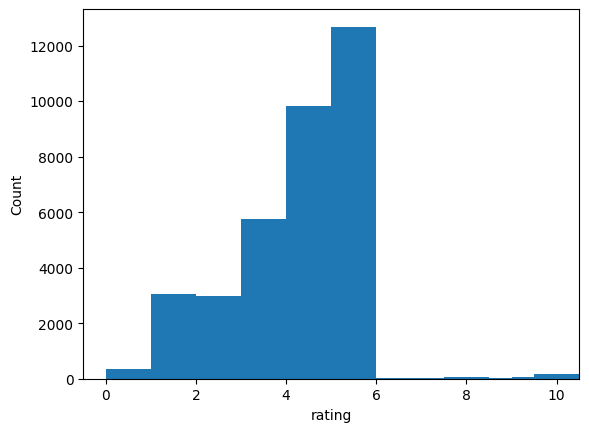

In [7]:
# Plot mean median
import matplotlib.pyplot as plt
plt.hist(df1['reviews.rating'], bins=20, width=1)
plt.xlabel('rating')
plt.ylabel('Count')
plt.show()

In [8]:
# ค่า Rating ที่เป็นไปได้
df1 = df1[df1['reviews.rating'].isin([5.0, 4.0, 3.0, 2.0, 1.0])]
df1.dropna(subset=['reviews.text','reviews.title'], inplace = True)

# เติมค่าสูญหายด้วยฐานนิยม (Mode)
df1['reviews.date'].fillna(df1['reviews.date'].mode()[0], inplace = True)

<ipython-input-8-9613afb048f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(subset=['reviews.text','reviews.title'], inplace = True)
<ipython-input-8-9613afb048f0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['reviews.date'].fillna(df1['reviews.date'].mode()[0], inplace = True)


## **Combining all 3 Datasets**

### Data Preprocessing
* ทำการ Cleaning Data สำหรับข้อความในตัวแปร reviews.text
  * Drop ค่าสูญหาย (NaN) ทั้งแถว
  * ทำการกำจัดเครื่องหมายวรรคตอนและ Stopwords
* ทำการ Classify Data จากตัวแปร reviews.rating
  * ถ้า reviews.rating >= 3 จะจัดเป็นกลุ่ม 1 (Positive) และ reviews.rating < 3 จะจัดเป็นกลุ่ม -1 (Negative)
  * สกัด Keywords ด้วย Natural Language Toolkit (NLTK)

#### Save the Final Dataset after removed duplicates

In [9]:
df_combined = pd.concat([df1, df2, df3], ignore_index=True) # Combine all 3 Datasets
df_combined = df_combined.drop_duplicates() # Drop any possible duplicates
df_combined.to_csv('combined_hotel_reviews.csv', index=False) # Save the combined DataFrame to a CSV file
print("Combined DataFrame saved to 'combined_hotel_reviews.csv'")

Combined DataFrame saved to 'combined_hotel_reviews.csv'


In [10]:
df_combined.tail(2)

,categories,city,country,name,province,reviews.date,reviews.dateAdded,reviews.rating,reviews.text,reviews.title
53589,"Hotels,Corporate Lodging,Lodging,Hotels Motels...",Asheville,US,Hampton Inn Suites Asheville Biltmore Village,NC,2019-01-29,2018-01-18,5.0,Very clean hotel. We booked an over-sized room...,Great Stay and close to downtown Asheville
53590,"Hotels and motels,Hotel",Lynchburg,US,Comfort Inn Suites-lynchburg,VA,2019-01-30,2016-05-08,5.0,We have visited this property multiple times o...,Another Incredible Stay!


#### ดูการกระจายตัวของตัวแปร Rating (ต้องอยู่ในช่วง 1.0 - 5.0)

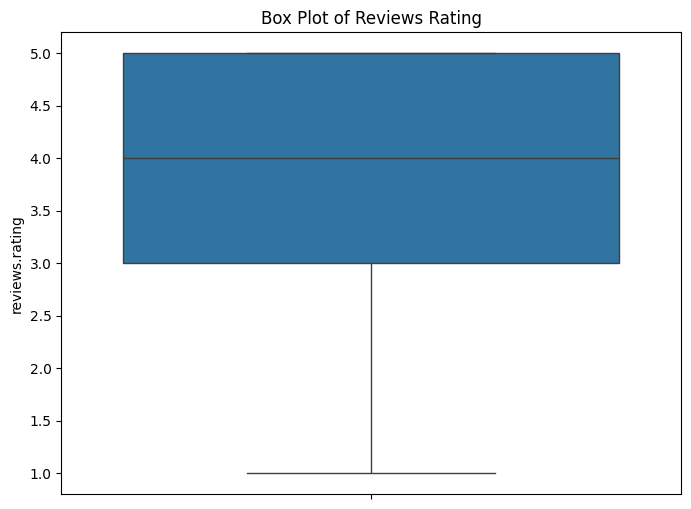

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(y=df_combined['reviews.rating'])
plt.title('Box Plot of Reviews Rating')
plt.show()

In [61]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer

df_combined = pd.read_csv('combined_hotel_reviews.csv')

* Remove Missing Value by Row

In [19]:
df_combined[df_combined['reviews.text'].isnull() == True]

,categories,city,country,name,province,reviews.date,reviews.dateAdded,reviews.rating,reviews.text,reviews.title
35900,"Hotel,Hotels and motels",Charleston,US,Holiday Inn Express Charleston Dwtn - Ashley R...,SC,2015-06-04,2015-10-23,3.0,NaN,Review


In [20]:
# กำจัดแถวที่บทวิจารณ์มีค่าเป็น NaN
df_combined = df_combined.dropna(subset=['reviews.text'])

* Prepare reviews.text for Translation (Positive/Negative Review)

In [21]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df_combined['reviews.text'] = df_combined['reviews.text'].apply(clean_text)
df_combined['label'] = df_combined['reviews.rating'].apply(lambda x: 1 if x >= 3 else -1) # การจำแนกข้อมูลด้วยการแบ่งจาก Rating

### Data Visualization

In [62]:
import plotly.express as px
import pandas as pd

# นับจำนวนโรงแรมในแต่ละรัฐ (province)
province_counts = df_combined['province'].value_counts().reset_index()
province_counts.columns = ['province', 'count']

# สร้าง Choropleth Map ของโรงแรมในแต่ละรัฐในสหรัฐฯ
fig = px.choropleth(province_counts,
                    locations='province',
                    locationmode="USA-states",
                    color='count',
                    hover_name='province',
                    color_continuous_scale='Blues',  # เปลี่ยนโทนสีเป็นฟ้าอ่อน
                    scope="usa",
                    labels={'count':'Number of Hotels'},
                    title='Distribution of Hotels in the USA by Province')

fig.show()

In [64]:
!pip install plotly geopy

In [65]:
# แปลงคอลัมน์ date_column เป็น datetime
df_combined['reviews.date'] = pd.to_datetime(df_combined['reviews.date'])
df_combined['reviews.date']

,reviews.date
0,2002-05-16
1,2002-06-17
2,2002-07-05
3,2002-08-01
4,2002-09-05
...,...
53239,2019-01-29
53240,2019-01-29
53241,2019-01-29
53242,2019-01-29


<ipython-input-66-00e6db65f5a2>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



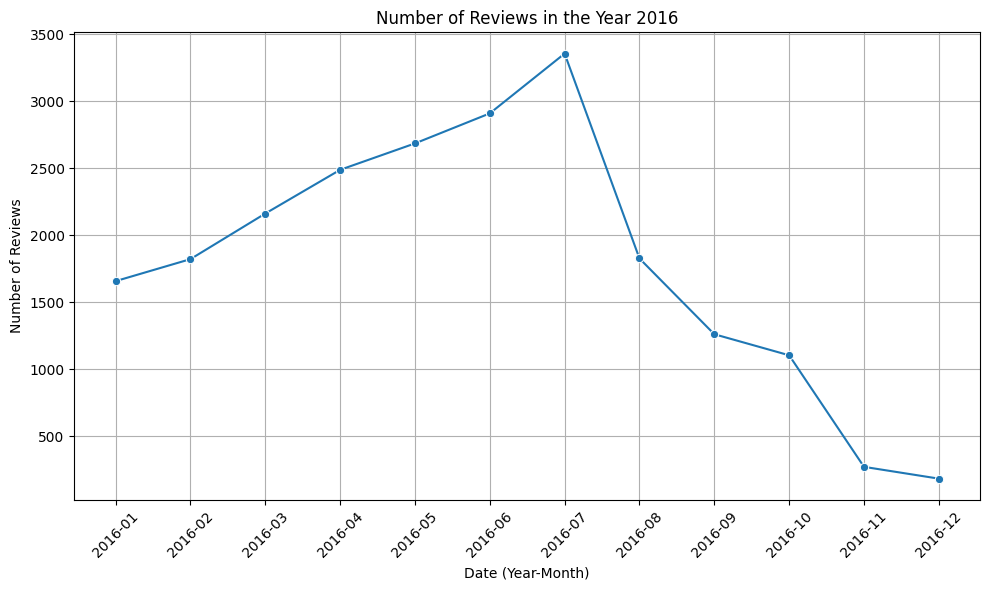

In [66]:
# สร้างคอลัมน์ปี
df_combined['year'] = df_combined['reviews.date'].dt.year

# นับจำนวนรีวิวในแต่ละปี
reviews_per_year = df_combined['year'].value_counts()

# หาปีที่มีรีวิวมากที่สุด
most_reviews_year = reviews_per_year.idxmax()

# กรองข้อมูลเฉพาะปีที่มีรีวิวมากที่สุด
df_most_reviews_year = df_combined[df_combined['year'] == most_reviews_year]

# สร้างคอลัมน์ year_month สำหรับแยกปีและเดือน
df_most_reviews_year['year_month'] = df_most_reviews_year['reviews.date'].dt.to_period('M')

# นับจำนวนรีวิวต่อเดือนในปีที่มีรีวิวมากที่สุด
reviews_per_month = df_most_reviews_year['year_month'].value_counts().sort_index()

# สร้าง Visualization สำหรับปีที่มีรีวิวมากที่สุด
plt.figure(figsize=(10,6))
sns.lineplot(x=reviews_per_month.index.astype(str), y=reviews_per_month.values, marker="o")
plt.xticks(rotation=45)
plt.title(f'Number of Reviews in the Year {most_reviews_year}')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Step 2: Non-English Reviews Translation**
## **Combined Dataset - combined_hotel_reviews.csv**
ใช้ชุดข้อมูลบทวิจารณ์โรงแรมทั้ง 3 ชุดที่ได้ผ่านกระบวนการ Preprocessing และรวมกันเป็นหนึ่งชุดข้อมูลมาแล้ว

เพื่อทำการสกัดคุณลักษณะต่อไปดังนี้

1. สร้าง Feature ระบุภาษาของบทวิจารณ์ (review.text)
2. ทำการแปลงบทวิจารณ์ (review.text) ที่ไม่ใช่ภาษาอังกฤษ ให้เป็นภาษาอังกฤษ

URL: https://www.kaggle.com/datasets/datafiniti/hotel-reviews/data

## **Feature Extraction - สร้าง Feature ระบุภาษาของบทวิจารณ์ (review.text)**

### **การตรวจจับภาษา** - Language detection for Feature: review.text

In [23]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=187a7f039e7beb928fd9222ea1dbfcac99941c8b080a2de9be3ef74c3dbc750d
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [1]:
from langdetect import detect, DetectorFactory
import langdetect

In [ ]:
DetectorFactory.seed = 0 # เลือกวิธีการระบุภาษา (0 คือ ระบุตาม library ของ langdetect)
def detect_language(text):
    if isinstance(text, str) and not pd.isna(text): # ตรวจสอบว่าข้อความเป็น str และไม่ใช่ค่า NaN
        try:
            return detect(text)
        except langdetect.lang_detect_exception.LangDetectException:
            return "unknown"
    else:
        return "unknown"

# Detect language for Feature: reviews.text
df_combined['reviews.text_language'] = df_combined['reviews.text'].apply(detect_language)
#df_combined['reviews.title_language'] = df_combined['reviews.title'].apply(detect_language) กรณีที่อยากระบุภาษาของ Title
df_combined.to_csv('hotel_reviews_languages.csv', index=False) # Save ไว้จะได้ไม่ต้องมา Run ใหม่

In [5]:
df_combined = pd.read_csv('hotel_reviews_languages.csv')

df_combined[['reviews.text','reviews.text_language']].head()

,reviews.text,reviews.text_language
0,Nice City Classic Great location. We stayed an...,en
1,Big fan I have stayed at The Governor on sever...,en
2,Convenient Location and Price While vacationin...,en
3,The hotel was very nice. Has a beautiful outdo...,en
4,Perfect My girlfriend and I stayed here for ou...,en


In [6]:
df_combined['reviews.text_language'].value_counts()

,count
reviews.text_language,
en,51059
fr,454
es,332
de,264
af,158
it,151
pt,121
no,86
da,78


### **Data Cleaning** - บทวิจารณ์ที่คาดว่าเป็น Spam (unknown)

In [7]:
df_combined[df_combined['reviews.text_language'] == 'unknown'].head(2)

,categories,city,country,name,province,reviews.date,reviews.dateAdded,reviews.rating,reviews.text,reviews.title,cleaned_review,label,reviews.text_language
1535,Hotels,North Myrtle Beach,US,Beach Cove 411 Tower A Sierra's 1 Bedroom Cond...,Cherry Grove,2012-04-06,2017-03-17,5.0,http://www.beachcove520.com/,Great Staff!,httpwwwbeachcove520com,1,unknown
3071,Hotels,Irving,US,H��tel Sezz Paris,TX,2013-09-18,2016-10-31,1.0,! ! ! ! 210 . ! .,������ ������ ������ ������ ������������������.,210,-1,unknown


* Drop rows where 'reviews.text_language' is 'unknown'

In [8]:
df_combined = df_combined[df_combined['reviews.text_language'] != 'unknown']

### นับจำนวนบทวิจารณ์ (reviews.text) ที่ไม่ใช่ภาษาอังกฤษ

In [9]:
non_english_reviews = df_combined[df_combined['reviews.text_language'] != 'en'] # สร้าง DataFrame รวบรวมแถวที่ไม่ใช่ภาษาอังกฤษ

total_non_english_reviews = len(non_english_reviews) # ทำการนับจำนวนแถวที่ไม่ใช่ภาษาอังกฤษ
print(f"Total number of reviews that are not English: {total_non_english_reviews}")

Total number of reviews that are not English: 2149


## **Feature Transformation (Translation) - ทำการแปลงบทวิจารณ์ (review.text) ที่ไม่ใช่ภาษาอังกฤษ ให้เป็นภาษาอังกฤษ**

### **Data Transformation** - ใช้ Library googletrans เพื่อแปลงภาษาในบทวิจารณ์ (reviews.text) จาก Non-English ให้เป็น English

In [10]:
!pip install googletrans==3.1.0a0

In [10]:
from googletrans import Translator
translator = Translator() # สร้าง Translator Object

In [11]:
def translate_to_english(text): # ฟังก์ชันสำหรับการแปลงภาษาบทวิจารณ์
    if isinstance(text, str) and not pd.isna(text):
        try:
            translated = translator.translate(text, dest='en')
            return translated.text
        except:
            return text # ถ้าการแปลล้มเหลว จะคืนค่า text ต้นฉบับ
    else:
        return text

In [12]:
# เรียกใช้ฟังก์ชันการแปลงภาษาบนตัวแปร reviews.text
df_combined['reviews.text'] = df_combined['reviews.text'].apply(translate_to_english)

### **การตรวจจับภาษา** - หลังจากแปลงภาษาแล้ว

In [14]:
# อัปเดตตัวแปรระบุภาษาว่าเป็นภาษาอังกฤษหรือยัง
df_combined['reviews.text_language'] = df_combined['reviews.text'].apply(detect_language)

* จำนวนบทวิจารณ์ (reviews.text) ที่ไม่ใช่ภาษาอังกฤษต้องลดลง

In [16]:
non_english_reviews = df_combined[df_combined['reviews.text_language'] != 'en']

total_non_english_reviews = len(non_english_reviews)
print(f"Total number of reviews that are not English: {total_non_english_reviews}")

Total number of reviews that are not English: 791


* Data Cleaning - ลบข้อมูลสูญหายทั้งแถว (ถ้ามี)

In [36]:
df_combined.dropna(inplace=True)

In [37]:
df_combined['reviews.text'].isnull().sum()

0

* Save the Final Datset

In [38]:
df_combined.to_csv('final_df.csv', index=False)

# **Step 3: Train and Apply the Models on the Final Dataset**
## **Final Dataset - hotel_reviews_translated.csv**
เรียกใช้ตัวแบบการจำแนกและตัวแบบการแนะนำลงในชุดข้อมูล **hotel_reviews_translated.csv** เพื่อทำการแนะนำโรงแรมที่เหมาะสมจากความต้องการของผู้ที่อยากจะเข้าพัก
* Train ตัวแบบการจำแนก Support Vector Machine (SVM)
* Train ตัวแบบการแนะนำ TF-IDF + Cosine Similarity (Content-Based Filtering)

### Train the SVM Classification Model
เมื่อเทียบกับ Logistic Regression (ด้วย TF-IDF) และ Naive Bayes (MultinomialNB) แล้วเราพบว่า

**Support Vector Machine เป็นโมเดลที่มีความแม่นยำสูงสุด ในการทำนายบทวิจารณ์ที่เป็น Negative และบทวิจารณ์ที่เป็น Positive**

In [29]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [39]:
final_df = pd.read_csv('final_df.csv')

In [40]:
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(final_df['reviews.text'])
y = final_df['label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_clf = SVC(kernel='linear') # Model Training
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test) # ทำนายบน Test Set
print("SVM Classification Results:\n", classification_report(y_test, y_pred_svm))

SVM Classification Results:
               precision    recall  f1-score   support

          -1       0.76      0.56      0.64      1681
           1       0.92      0.97      0.94      8958

    accuracy                           0.90     10639
   macro avg       0.84      0.76      0.79     10639
weighted avg       0.89      0.90      0.90     10639



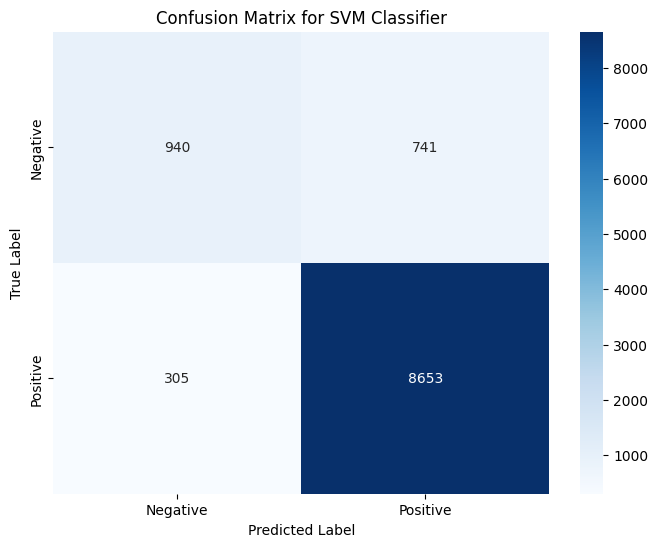

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_svm) # คำนวณ confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()

### Apply the Recommendation System
ระบบการแนะนำโรงแรมที่ตั้งอยู่ในทั่วสหรัฐอเมริกาจากความต้องการของลูกค้า

In [42]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [43]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [52]:
def clean_text(text): # ฟังก์ชันในการแปลงให้ Input เป็นข้อความที่พร้อมนำไปสกัดคำสำคัญ
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

def extract_keywords(text): # ฟังก์ชันสำหรับการสกัดคำสำคัญ
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    keywords = [word for word in tokens if word.isalnum() and word not in stop_words]
    return keywords

tfidf_matrix = tfidf.fit_transform(final_df['reviews.text'])

def recommend_hotel(input_review, n_recommendations=5): # รับ Input เข้ามา
    input_review_cleaned = clean_text(input_review) # Clean Input เช่น กำจัดคำที่ไม่สำคัญ
    input_review_tfidf = tfidf.transform([input_review_cleaned]) # คำนวณ TF-IDF Vector ของ Input
    input_keywords = extract_keywords(input_review_cleaned) # เรียกใช้ฟังก์ชันสกัด Keywords

    # คำนวณค่าความเหมือน Cosine ระหว่าง Input TF-IDF Vector กับ TF-IDF matrix ของทุกบทวิจารณ์
    cosine_sim = cosine_similarity(input_review_tfidf, tfidf_matrix).flatten()

    # รวมคะแนนของค่าความเหมือน Cosine กับคะแนน Keyword
    keyword_scores = [len(set(input_keywords) & set(extract_keywords(review))) for review in final_df['reviews.text']]
    keyword_scores = np.array(keyword_scores)
    # ใช้ค่าถ่วงน้ำหนัก 0.7 และ 0.3 คูณเข้าไปตามลำดับ
    combined_scores = 0.7 * cosine_sim + 0.3 * keyword_scores # ได้คะแนนความเหมาะสมของแต่ละโรงแรม

    # เรียงลำดับผลลัพธืการแนะนำ ตามคะแนนความเหมาะสมแต่ละโรงแรม
    similar_indices = combined_scores.argsort()[-n_recommendations:][::-1]
    return final_df.iloc[similar_indices] # คืนค่า Top n_rocommendations (Default = 5) ในรูปของ Pandas DataFrame

### Classify whether Review is positive or negative

* เปลี่ยนผลการจำแนกเป็น positive และ negative

In [48]:
#final_df['label'] = final_df['label'].replace({1: 'positive', -1: 'negative'})

### Test on Application

* **INPUT**

In [53]:
input_review = "I want a hotel with a pool."

* **PROCESS**

In [59]:
recommended_hotels = recommend_hotel(input_review)
recommended_hotels = recommended_hotels[['name','city',
                                         'province','country',
                                         'reviews.rating','reviews.title',
                                         'reviews.text']].sort_values(by=['reviews.rating'], ascending=False)

In [57]:
#final_df.head(1)

,categories,city,country,name,province,reviews.date,reviews.dateAdded,reviews.rating,reviews.text,reviews.title,label,reviews.text_language
0,"Corporate Lodging,Banquet Halls & Reception Fa...",Portland,US,The Governor Hotel,OR,2002-05-16,2016-11-14,5.0,nice city classic great location we stayed and...,Great business hotel,positive,en


* **OUTPUT**

In [60]:
pd.options.display.max_colwidth = None
recommended_hotels

,name,city,province,country,reviews.rating,reviews.title,reviews.text
7648,Holiday Inn Express Hotel & Suites Emporia,Emporia,VA,US,5.0,Hotel,the hotel itself was nice but we were disappointed because i booked this hotel because we want to use the pool and the hot tub after a long ride nice to have but they were not available under repairs
49717,Sleep Inn and Suites,Rapid City,SD,US,5.0,Excellant,this is a very nice clean and very friendly hotel the entire staff is friendly is very helpful breakfast was fantastic with everything you could possibly want the room was spotless the pool was perfect great hotel great stay would stay again if im in the area
22577,Sportsmen's Lodge,Studio City,CA,US,4.0,GREAT pool and location.,went with my son to go to universal studios location was great pool is the best rooms are adequate clean standard size but no fridge be sure to ask for one if you want one the hotel is great for location and pool
45171,Anaheim Del Sol Inn,Anaheim,CA,US,4.0,Great place to stay!,enjoyed staying here and having a continental breakfast it is right across from disney and that is perfect nice spacious rooms and a pool and hot tub if you want one i was very pleased with this hotel
41700,French Quarter Suites Hotel,New Orleans,LA,US,2.0,Not very happy with the service.,hotel looks very dark weird smell 105 dollars per night complementary internet and continental breakfast location is in french area very handy if u want to go out small pool of u want to swimming 25 dollars parking
